In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt 
import libpysal
import spopt
import os
import seaborn as sns
from shapely.ops import cascaded_union
from spopt.region import MaxPHeuristic as MaxP
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Example Process

In this notebook, we will illustrate the clustering process for one municipality. As the raw population and household count data at the grid cell level is not public, we use some dummy data in this notebook. The raw data for this analysis are:
- Municipality broken down into polygons using OSM street network
- Grid cells mapped to polygons with households and population counts 

Note: We only included the minimum value over the last 30 years of households and population. Since the final regions need to adhere to privacy constraints of 50 households and 100 people over the entire duration, it suffices to look at the minima of these values.


### Derived Polygon data



In [2]:
polygon = gpd.read_file("../../data/polygon_580.geojson")
polygon = polygon.set_crs("epsg:25832",allow_override=True)

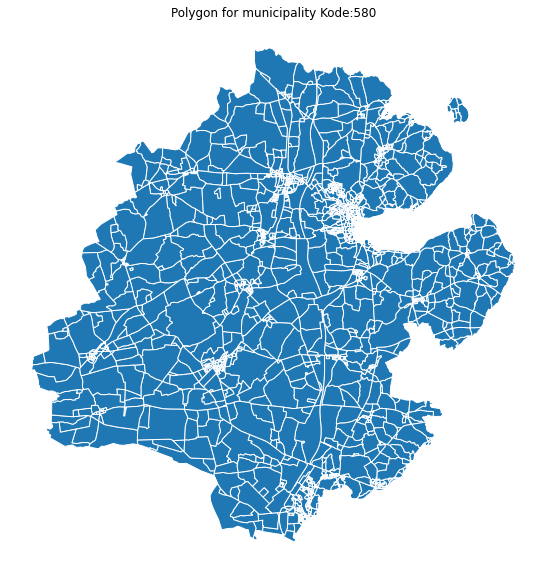

In [4]:
fig,ax = plt.subplots(figsize=(15,10))
p = polygon.plot(ax=ax, edgecolor='white')
ax.title.set_text('Polygon for municipality Kode:580')
p.axes.get_xaxis().set_visible(False)
p.axes.get_yaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)


## Polygons mapped to grid cells

In [5]:
gridded_polygon = gpd.read_file("../../data/gridded_polygon_580.geojson")
gridded_polygon = gridded_polygon.set_crs("epsg:25832",allow_override=True)

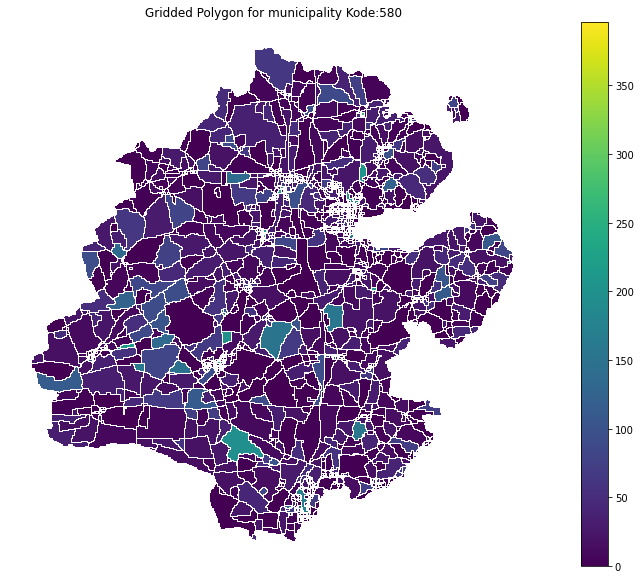

In [7]:
fig,ax = plt.subplots(figsize=(15,10))
p = gridded_polygon.plot(column='min_population', ax=ax, edgecolor='white', legend=True)
ax.title.set_text('Gridded Polygon for municipality Kode:580')
p.axes.get_xaxis().set_visible(False)
p.axes.get_yaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)


### Max-P Regionalization

To cluster the gridded polygons, we first need to do some additional transformations

**Deriving Constraint:** Max-P only accepts one constraint, but we have to adhere to minimum requirements for both household (50) and population count (100). We therefore, take the minimum of twice the household count and population count, which can then be set to a threshold of 100. 

**Challenges with Islands:** One of the main challenges with this approach, particularly for Denmark, is the presence of islands. Based on conversations with stakeholders, it was decided that it for the first pass of analysis, we can exclude islands from the regionalization as it doesn't make sense to combine them with parts of the mainland in many cases. In this example, you'll note that islands have been excluded from the clustering step. We have some development work where we set a distance limit for islands to be clustered, which helps address cases of small islands in shallow waters/separated by a canal. 

**Adjacency choice:** Given the final clustering is done on combinations of grid cells, we chose to use Rook's contiguity for the spatial weights matrix calculation to avoid cells touching at a point from being clustered together. We compared and measured the results from different choices using the compactness of the final regions

In [9]:
## Calculating the constraint variable
gridded_polygon['min_val'] = [min(2*x,y) for x,y in zip(gridded_polygon.min_households, gridded_polygon.min_population)]
gridded_polygon[['min_val']] = gridded_polygon[['min_val']].fillna(0)

## Weights matrix and excluding islands
w = libpysal.weights.Rook.from_dataframe(gridded_polygon)
gridded_polygon['poly_comp'] = w.component_labels
comp_vals = gridded_polygon.groupby('poly_comp').sum()[['min_val']].reset_index()
components_to_cluster = list(comp_vals[comp_vals.min_val>=50].poly_comp)
gridded_polygon_minus_islands = gridded_polygon[gridded_polygon.poly_comp.isin(components_to_cluster)]
w_rook = libpysal.weights.Rook.from_dataframe(gridded_polygon_minus_islands)

## Max-P regionalization
threshold = 100
top_n = 2
model = MaxP(gridded_polygon_minus_islands, w_rook, [], 'min_val', threshold, top_n)
model.solve()

## Derived regions and its metrics
gridded_polygon_minus_islands['max_p'] = model.labels_

regions = gridded_polygon_minus_islands.dissolve(by='max_p', aggfunc='sum').reset_index()
compactness = regions.area * 4 * np.pi / (regions.boundary.length**2)
compactness = compactness.to_frame().reset_index().rename(columns={0:'compactness','max_p':'clus'})

## Results

<AxesSubplot:xlabel='compactness', ylabel='Count'>

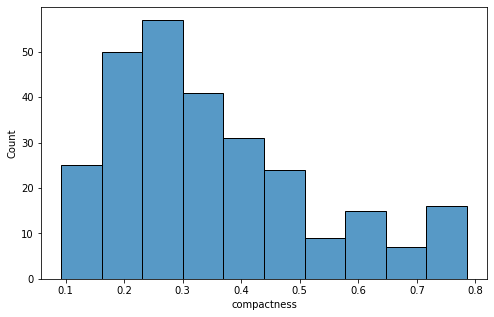

In [10]:
fig,ax = plt.subplots(figsize=(8,5))
sns.histplot(compactness.compactness,ax=ax)

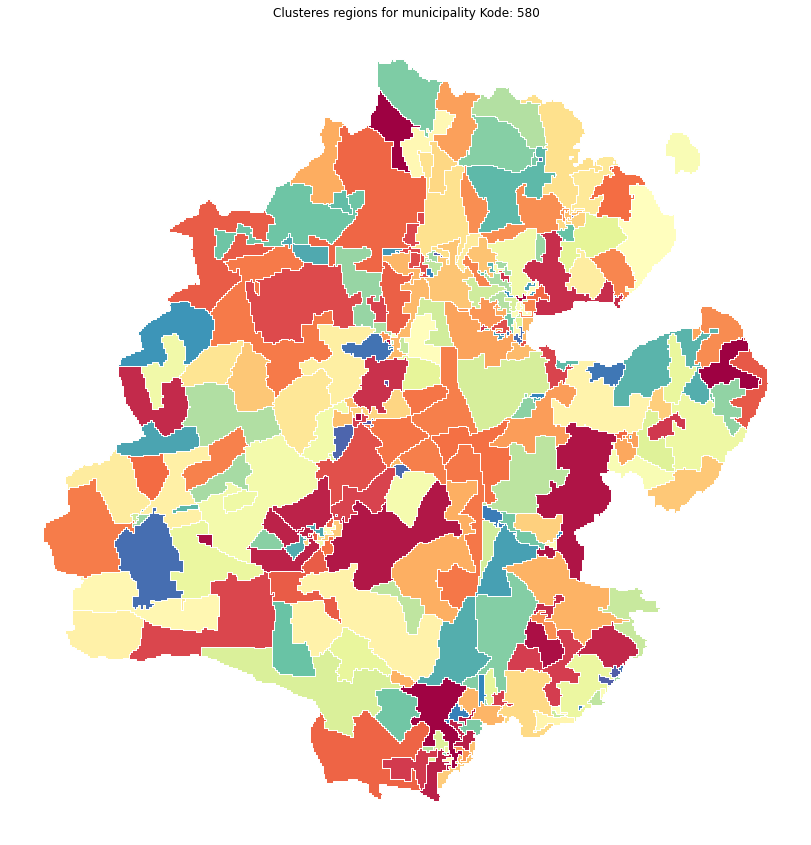

In [12]:
fig,ax = plt.subplots(figsize=(20,15))
p = regions.plot(column='max_p',ax=ax, cmap="Spectral", edgecolor='white')
ax.title.set_text('Clusteres regions for municipality Kode: 580')
p.axes.get_xaxis().set_visible(False)
p.axes.get_yaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
